# Capstone F2 Week 3 - Model Testing & Strategy

## The Challenge: Both Weeks Failed!

**Week 1:** 0.525 (rank 3/11)  
**Week 2:** 0.285 (rank 6/12) → DECLINED!  
**Best:** 0.611 (index 9, from initial data)  
**Problem:** Neither W1 nor W2 found the best region  
**Strategy:** Test multiple models, focus on BEST point

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
print('='*80)
print('CAPSTONE F2 WEEK 3 - MODEL TESTING APPROACH')
print('='*80)

CAPSTONE F2 WEEK 3 - MODEL TESTING APPROACH


## Load Data

In [12]:
X = np.load('f2_w3_inputs.npy')
Y = np.load('f2_w3_outputs.npy')

print(f'Data: {len(X)} samples, {X.shape[1]}D')
print(f'n/p: {len(X)/X.shape[1]:.2f}')

# Find best, W1, W2
best_idx = np.argmax(Y)
best_pt = X[best_idx]
best_val = Y[best_idx]

w1_pt = X[-2]
w1_val = Y[-2]
w1_rank = (Y >= w1_val).sum()

w2_pt = X[-1]
w2_val = Y[-1]
w2_rank = (Y >= w2_val).sum()

print(f'\nBest:   {best_val:.6f} (index {best_idx})')
print(f'Week 1: {w1_val:.6f} (rank {w1_rank})')
print(f'Week 2: {w2_val:.6f} (rank {w2_rank})')

print(f'\n⚠️ Week 2 DECLINED from Week 1!')
print(f'⚠️ BEST point is from initial data (not W1 or W2)!')

Data: 12 samples, 2D
n/p: 6.00

Best:   0.611205 (index 9)
Week 1: 0.524619 (rank 3)
Week 2: 0.284725 (rank 6)

⚠️ Week 2 DECLINED from Week 1!
⚠️ BEST point is from initial data (not W1 or W2)!


## Strategy Overview

In [13]:
print('\n' + '='*80)
print('STRATEGY: MODEL TESTING + FOCUS ON BEST')
print('='*80)

print(f'\n📊 The Situation:')
print(f'   Best:   {best_val:.6f} (initial data, index {best_idx})')
print(f'   Week 1: {w1_val:.6f} (rank 3 - okay)')
print(f'   Week 2: {w2_val:.6f} (rank 6 - WORSE!)')
print(f'   Best point: {best_pt}')

print(f'\n🎯 Key Insight:')
print(f'   Neither W1 nor W2 are close to BEST!')
print(f'   We should focus on the actual best point (index {best_idx})')
print(f'   Not on failed attempts (W1, W2)')

print(f'\n🔬 Model Testing Strategy:')
print(f'   Challenge: Only 12 samples (very small!)')
print(f'   n/p ratio: {len(X)/X.shape[1]:.2f} (good, but limited data)')
print(f'   ')
print(f'   We will test MULTIPLE models:')
print(f'   1. Linear SVM (standard baseline)')
print(f'   2. Random Forest (handles non-linearity)')
print(f'   3. Gradient Boosting (powerful ensemble)')
print(f'   4. Decision Tree (simple, interpretable)')
print(f'   ')
print(f'   Pick the model with BEST cross-validation score')
print(f'   If ALL fail (<60%) → Use Pure GP (no classifier)')

print(f'\n📍 Candidate Generation:')
print(f'   50% Best Model-approved (if model reliable)')
print(f'   30% LOCAL around BEST point (not W2!)')
print(f'   20% RANDOM exploration')

print(f'\n💡 Why Focus on BEST, not W2?')
print(f'   W2 got WORSE (rank 6)')
print(f'   W1 was mediocre (rank 3)')
print(f'   BEST (rank 1) is what actually worked!')
print(f'   Distance W2→BEST: {np.linalg.norm(w2_pt - best_pt):.4f}')
print(f'   ')
print(f'   Strategy: Return to success, refine it')

print('\n' + '='*80)


STRATEGY: MODEL TESTING + FOCUS ON BEST

📊 The Situation:
   Best:   0.611205 (initial data, index 9)
   Week 1: 0.524619 (rank 3 - okay)
   Week 2: 0.284725 (rank 6 - WORSE!)
   Best point: [0.70263656 0.9265642 ]

🎯 Key Insight:
   Neither W1 nor W2 are close to BEST!
   We should focus on the actual best point (index 9)
   Not on failed attempts (W1, W2)

🔬 Model Testing Strategy:
   Challenge: Only 12 samples (very small!)
   n/p ratio: 6.00 (good, but limited data)
   
   We will test MULTIPLE models:
   1. Linear SVM (standard baseline)
   2. Random Forest (handles non-linearity)
   3. Gradient Boosting (powerful ensemble)
   4. Decision Tree (simple, interpretable)
   
   Pick the model with BEST cross-validation score
   If ALL fail (<60%) → Use Pure GP (no classifier)

📍 Candidate Generation:
   50% Best Model-approved (if model reliable)
   30% LOCAL around BEST point (not W2!)
   20% RANDOM exploration

💡 Why Focus on BEST, not W2?
   W2 got WORSE (rank 6)
   W1 was mediocr

## Model Testing - Find Best Classifier

In [14]:
print('\n' + '='*80)
print('TESTING MULTIPLE MODELS')
print('='*80)

threshold = np.percentile(Y, 70)
y_binary = (Y > threshold).astype(int)

print(f'\nBinary threshold (70th percentile): {threshold:.6f}')
print(f'Good samples: {(y_binary==1).sum()}')
print(f'Bad samples: {(y_binary==0).sum()}')

# Define models to test
models_to_test = [
    ('Linear SVM (C=0.1)', SVC(kernel='linear', C=0.1, probability=True, random_state=42)),
    ('Linear SVM (C=1.0)', SVC(kernel='linear', C=1.0, probability=True, random_state=42)),
    ('Linear SVM (C=2.0)', SVC(kernel='linear', C=2.0, probability=True, random_state=42)),
    ('RBF SVM (C=1.0)', SVC(kernel='rbf', C=1.0, probability=True, random_state=42)),
    ('Random Forest (n=10)', RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)),
    ('Random Forest (n=20)', RandomForestClassifier(n_estimators=20, max_depth=3, random_state=42)),
    ('Gradient Boost (n=10)', GradientBoostingClassifier(n_estimators=10, max_depth=2, random_state=42)),
    ('Decision Tree (d=2)', DecisionTreeClassifier(max_depth=2, random_state=42)),
    ('Decision Tree (d=3)', DecisionTreeClassifier(max_depth=3, random_state=42)),
]

print(f'\nTesting {len(models_to_test)} models with 3-fold CV...')
print('\n' + '─'*80)

results = []
for name, model in models_to_test:
    try:
        cv_scores = cross_val_score(model, X, y_binary, cv=3)
        mean_score = cv_scores.mean()
        std_score = cv_scores.std()
        
        results.append({
            'name': name,
            'model': model,
            'mean': mean_score,
            'std': std_score
        })
        
        status = '✓' if mean_score >= 0.60 else '✗'
        print(f'{name:<25} {mean_score:>6.1%} ± {std_score:>5.1%}  {status}')
    except Exception as e:
        print(f'{name:<25} FAILED: {str(e)[:30]}')

print('─'*80)

# Find best model
if results:
    best_model_result = max(results, key=lambda x: x['mean'])
    best_model_name = best_model_result['name']
    best_model = best_model_result['model']
    best_model_cv = best_model_result['mean']
    
    print(f'\n✓ BEST MODEL: {best_model_name}')
    print(f'  CV Score: {best_model_cv:.1%} ± {best_model_result["std"]:.1%}')
    
    if best_model_cv >= 0.70:
        print(f'  Status: EXCELLENT (≥70%)')
        use_model = True
    elif best_model_cv >= 0.60:
        print(f'  Status: GOOD (≥60%)')
        use_model = True
    else:
        print(f'  Status: POOR (<60%)')
        print(f'  ⚠️ Will use Pure GP (no classifier)')
        use_model = False
    
    # Train best model on all data
    if use_model:
        best_model.fit(X, y_binary)
        print(f'\n✓ Trained {best_model_name} on all data')
        
        # Get feature importance if available
        if hasattr(best_model, 'coef_'):
            weights = best_model.coef_[0]
            print(f'\nModel Weights:')
            for i, w in enumerate(weights):
                direction = 'HIGH' if w > 0 else 'LOW'
                print(f'  X{i+1}: {w:+.3f} → Want {direction}')
        elif hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
            print(f'\nFeature Importances:')
            for i, imp in enumerate(importances):
                print(f'  X{i+1}: {imp:.3f}')
else:
    print(f'\n✗ ALL MODELS FAILED')
    use_model = False
    best_model_name = 'None'


TESTING MULTIPLE MODELS

Binary threshold (70th percentile): 0.382608
Good samples: 4
Bad samples: 8

Testing 9 models with 3-fold CV...

────────────────────────────────────────────────────────────────────────────────
Linear SVM (C=0.1)         66.7% ± 11.8%  ✓
Linear SVM (C=1.0)         66.7% ± 11.8%  ✓
Linear SVM (C=2.0)         66.7% ± 11.8%  ✓
RBF SVM (C=1.0)            58.3% ± 11.8%  ✗
Random Forest (n=10)       58.3% ± 11.8%  ✗
Random Forest (n=20)       66.7% ± 11.8%  ✓
Gradient Boost (n=10)      58.3% ± 11.8%  ✗
Decision Tree (d=2)        75.0% ±  0.0%  ✓
Decision Tree (d=3)        75.0% ±  0.0%  ✓
────────────────────────────────────────────────────────────────────────────────

✓ BEST MODEL: Decision Tree (d=2)
  CV Score: 75.0% ± 0.0%
  Status: EXCELLENT (≥70%)

✓ Trained Decision Tree (d=2) on all data

Feature Importances:
  X1: 1.000
  X2: 0.000


## Train GP

In [15]:
kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50,
                              normalize_y=True, random_state=42)
gp.fit(X, Y)
print(f'GP R²: {gp.score(X, Y):.3f}')

GP R²: 0.507


## Generate Candidates

In [16]:
print('\nGenerating candidates...')
np.random.seed(42)

if use_model:
    print(f'\nUsing {best_model_name} for filtering...')
    
    # Generate candidates and get model predictions
    X_candidates = np.random.uniform(0, 1, (10000, 2))
    model_pred = best_model.predict(X_candidates)
    model_prob = best_model.predict_proba(X_candidates)[:, 1]
    
    # Model-approved (50%)
    if (model_pred == 1).sum() > 0:
        idx = np.where(model_pred == 1)[0]
        order = np.argsort(model_prob[idx])[::-1]
        X_model = X_candidates[idx[order[:min(5000, len(idx))]]]
    else:
        X_model = X_candidates[np.argsort(model_prob)[::-1][:5000]]
    
    print(f'  Model-approved: {len(X_model):,}')
else:
    print(f'\nNo model (Pure GP approach)...')
    X_model = np.random.uniform(0, 1, (3000, 2))
    print(f'  Random global: {len(X_model):,}')

# LOCAL around BEST point (not W2!)
print(f'\nGenerating LOCAL around BEST point (index {best_idx})...')
X_local = []
for _ in range(3000):
    c = best_pt + np.random.normal(0, 0.12, 2)
    c = np.clip(c, 0, 1)
    X_local.append(c)
X_local = np.array(X_local)
print(f'  Local (BEST): {len(X_local):,}')

# Random exploration
X_random = np.random.uniform(0, 1, (2000, 2))
print(f'  Random: {len(X_random):,}')

X_filtered = np.vstack([X_model, X_local, X_random])
print(f'\nTotal: {len(X_filtered):,} candidates')


Generating candidates...

Using Decision Tree (d=2) for filtering...
  Model-approved: 1,195

Generating LOCAL around BEST point (index 9)...
  Local (BEST): 3,000
  Random: 2,000

Total: 6,195 candidates


## GP Optimization

In [17]:
def expected_improvement(X_new, gp, y_best, xi=0.10):
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    improvement = mu - y_best - xi
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    return ei

y_best = Y.max()
ei_values = expected_improvement(X_filtered, gp, y_best, xi=0.10)
mu_all, sigma_all = gp.predict(X_filtered, return_std=True)

best_idx_ei = np.argmax(ei_values)
x_next = X_filtered[best_idx_ei]
mu_next = mu_all[best_idx_ei]
sigma_next = sigma_all[best_idx_ei]
ei_next = ei_values[best_idx_ei]

# Determine source
if best_idx_ei < len(X_model):
    source = f'{best_model_name}'
elif best_idx_ei < len(X_model) + len(X_local):
    source = 'LOCAL (BEST point)'
    dist_best = np.linalg.norm(x_next - best_pt)
else:
    source = 'RANDOM'

print('='*80)
print('WEEK 3 RECOMMENDATION')
print('='*80)
print(f'\nPoint: {x_next}')
print(f'Prediction: {mu_next:.6f} ± {sigma_next:.6f}')
print(f'EI: {ei_next:.6f}')
print(f'Source: {source}')

if source == 'LOCAL (BEST point)':
    print(f'\nDistance from BEST: {dist_best:.4f}')
    print(f'✓ Refining best known region!')

print(f'\nExpected gain: {((mu_next/y_best-1)*100):+.2f}%')

WEEK 3 RECOMMENDATION

Point: [1. 1.]
Prediction: 0.345636 ± 0.211759
EI: 0.003631
Source: LOCAL (BEST point)

Distance from BEST: 0.3063
✓ Refining best known region!

Expected gain: -43.45%


## ACQUISITION VISUALIZATIONS

Creating acquisition curves...


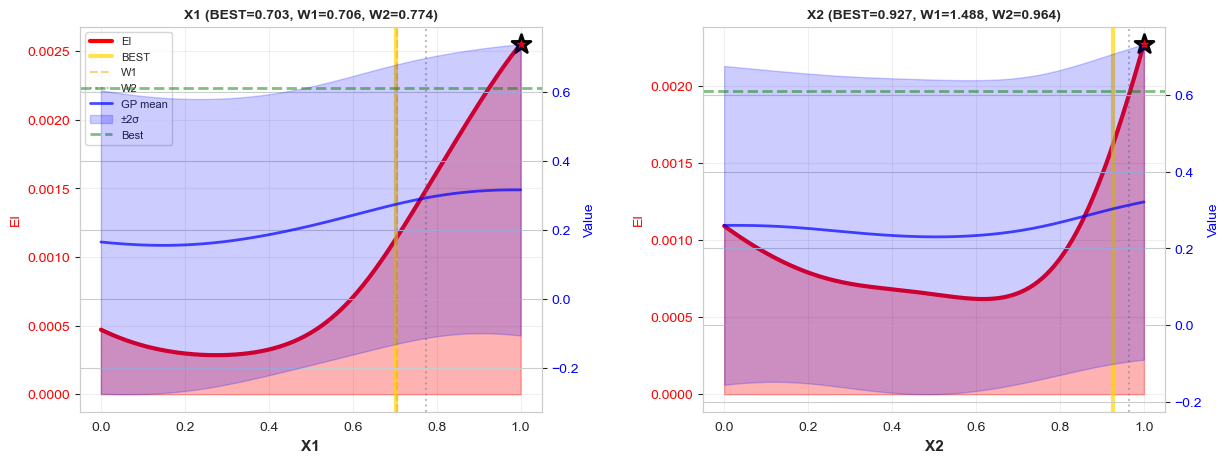

✓ Saved acquisition curves


In [18]:
print('Creating acquisition curves...')

fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2, hspace=0.35, wspace=0.35)

for dim in range(2):
    ax = fig.add_subplot(gs[0, dim])
    ax2 = ax.twinx()
    
    x1 = np.linspace(0, 1, 200)
    Xt = np.tile(X.mean(axis=0), (200, 1))
    Xt[:, dim] = x1
    
    m, s = gp.predict(Xt, return_std=True)
    e = expected_improvement(Xt, gp, y_best, 0.10)
    
    # GP plot
    ax2.plot(x1, m, 'b-', lw=2, alpha=0.7, label='GP mean')
    ax2.fill_between(x1, m - 2*s, m + 2*s, alpha=0.2, color='blue', label='±2σ')
    ax2.axhline(y_best, color='green', ls='--', alpha=0.5, lw=2, label='Best')
    ax2.set_ylabel('Value', color='blue', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # EI plot
    ax.plot(x1, e, 'r-', lw=3, label='EI')
    ax.fill_between(x1, 0, e, alpha=0.3, color='red')
    
    mi = np.argmax(e)
    ax.scatter(x1[mi], e[mi], color='red', s=200, marker='*',
              zorder=5, edgecolors='black', lw=2)
    
    # Mark BEST, W1, W2
    ax.axvline(best_pt[dim], color='gold', ls='-', alpha=0.7, lw=3, label='BEST')
    ax.axvline(w1_pt[dim], color='orange', ls='--', alpha=0.5, label='W1')
    ax.axvline(w2_pt[dim], color='gray', ls=':', alpha=0.5, label='W2')
    
    ax.set_xlabel(f'X{dim+1}', fontweight='bold', fontsize=11)
    ax.set_ylabel('EI', color='red', fontsize=10)
    ax.set_title(f'X{dim+1} (BEST={best_pt[dim]:.3f}, W1={w1_pt[dim]:.3f}, W2={w2_pt[dim]:.3f})',
                fontweight='bold', fontsize=10)
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xlim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    
    if dim == 0:
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.savefig('Capstone_F2_W3_acquisition.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved acquisition curves')

## RESULTS VISUALIZATION

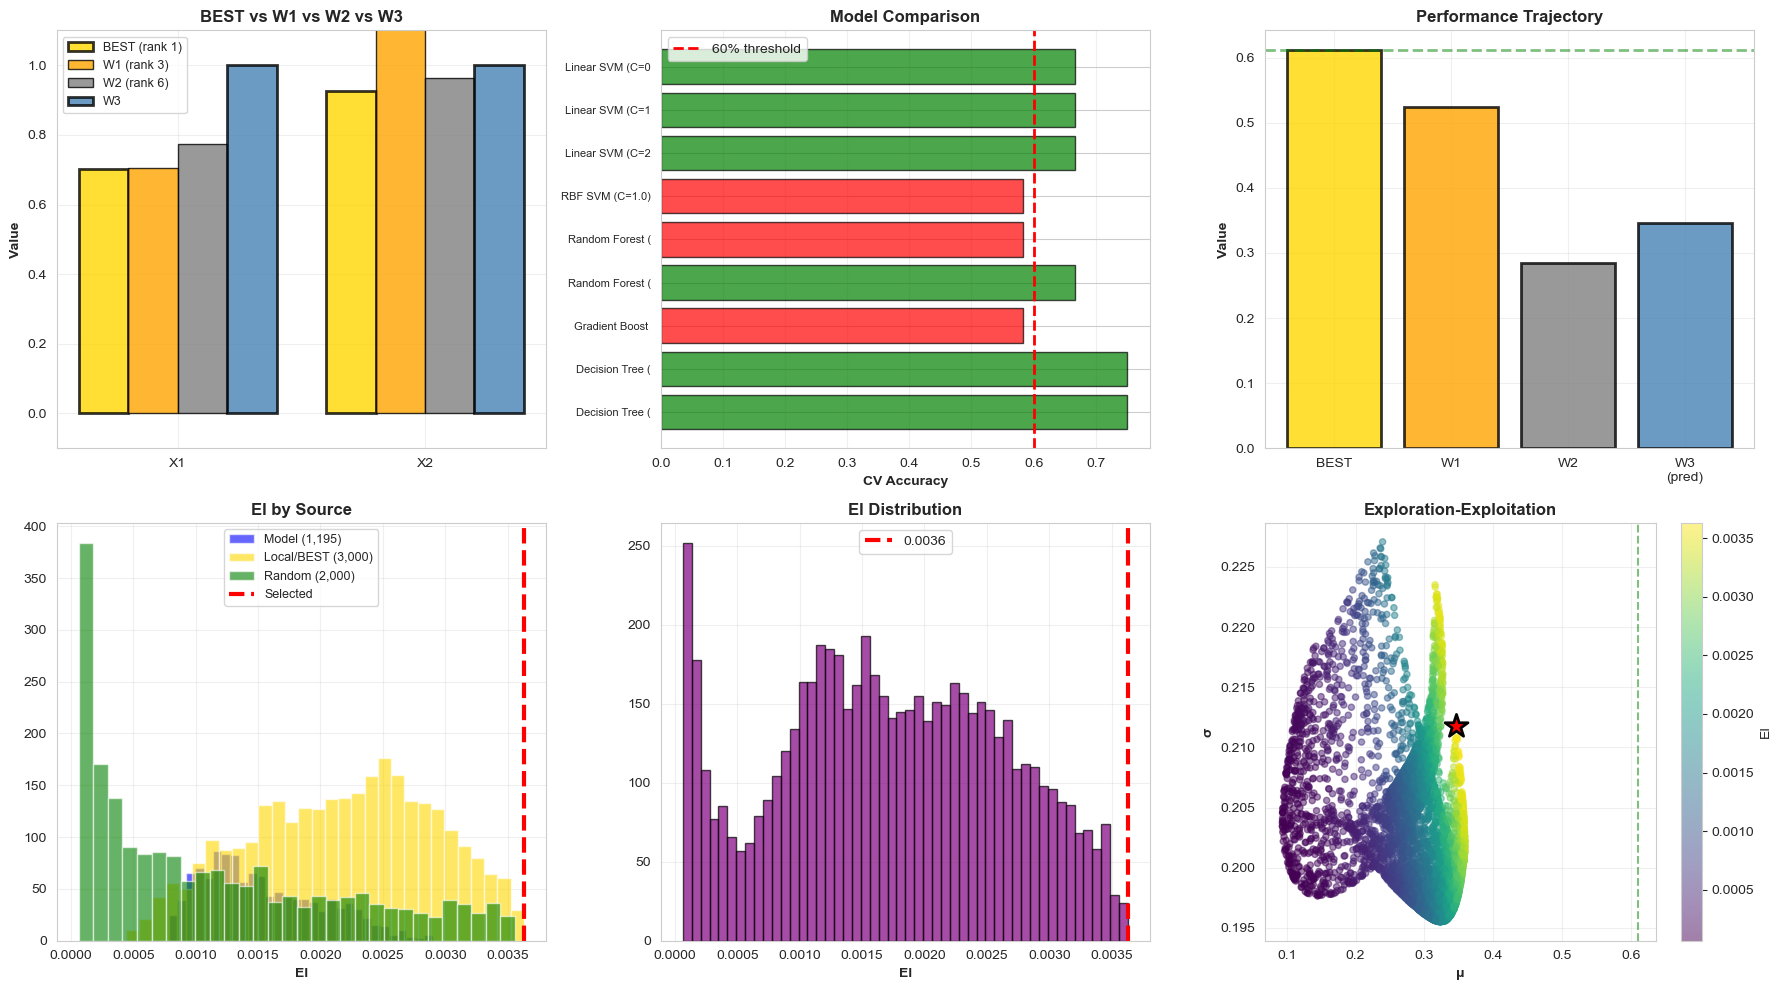

✓ Saved results


In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

dims = np.arange(2)
w = 0.2

# BEST vs W1 vs W2 vs W3
ax = axes[0, 0]
ax.bar(dims - 1.5*w, best_pt, w, label='BEST (rank 1)', alpha=0.8, color='gold', edgecolor='black', lw=2)
ax.bar(dims - 0.5*w, w1_pt, w, label='W1 (rank 3)', alpha=0.8, color='orange', edgecolor='black')
ax.bar(dims + 0.5*w, w2_pt, w, label='W2 (rank 6)', alpha=0.8, color='gray', edgecolor='black')
ax.bar(dims + 1.5*w, x_next, w, label='W3', alpha=0.8, color='steelblue', edgecolor='black', lw=2)
ax.set_xticks(dims)
ax.set_xticklabels([f'X{i+1}' for i in dims])
ax.set_ylabel('Value', fontweight='bold')
ax.set_title('BEST vs W1 vs W2 vs W3', fontweight='bold', fontsize=12)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)
ax.set_ylim(-0.1, 1.1)

# Model comparison
ax = axes[0, 1]
if results:
    model_names = [r['name'][:15] for r in results]
    model_scores = [r['mean'] for r in results]
    colors_model = ['green' if s >= 0.60 else 'red' for s in model_scores]
    bars = ax.barh(range(len(results)), model_scores, color=colors_model, alpha=0.7, edgecolor='black')
    ax.axvline(0.60, color='red', ls='--', lw=2, label='60% threshold')
    ax.set_yticks(range(len(results)))
    ax.set_yticklabels(model_names, fontsize=8)
    ax.set_xlabel('CV Accuracy', fontweight='bold')
    ax.set_title('Model Comparison', fontweight='bold', fontsize=12)
    ax.legend()
    ax.invert_yaxis()
    ax.grid(alpha=0.3, axis='x')
else:
    ax.text(0.5, 0.5, 'No models tested', ha='center', va='center', fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Performance trajectory
ax = axes[0, 2]
points = ['BEST', 'W1', 'W2', 'W3\n(pred)']
values = [best_val, w1_val, w2_val, mu_next]
colors_traj = ['gold', 'orange', 'gray', 'steelblue']
ax.bar(range(4), values, color=colors_traj, alpha=0.8, edgecolor='black', lw=2)
ax.axhline(y_best, color='green', ls='--', alpha=0.5, lw=2)
ax.set_xticks(range(4))
ax.set_xticklabels(points)
ax.set_ylabel('Value', fontweight='bold')
ax.set_title('Performance Trajectory', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3)

# EI by source
ax = axes[1, 0]
ei_model = ei_values[:len(X_model)]
ei_local = ei_values[len(X_model):len(X_model)+len(X_local)]
ei_rand = ei_values[len(X_model)+len(X_local):]
ax.hist(ei_model, bins=30, alpha=0.6, label=f'Model ({len(ei_model):,})', color='blue')
ax.hist(ei_local, bins=30, alpha=0.6, label=f'Local/BEST ({len(ei_local):,})', color='gold')
ax.hist(ei_rand, bins=30, alpha=0.6, label=f'Random ({len(ei_rand):,})', color='green')
ax.axvline(ei_next, color='red', ls='--', lw=3, label='Selected')
ax.set_xlabel('EI', fontweight='bold')
ax.set_title('EI by Source', fontweight='bold', fontsize=12)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# EI distribution
ax = axes[1, 1]
ax.hist(ei_values, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(ei_next, color='red', ls='--', lw=3, label=f'{ei_next:.4f}')
ax.set_xlabel('EI', fontweight='bold')
ax.set_title('EI Distribution', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

# Mu vs Sigma
ax = axes[1, 2]
sc = ax.scatter(mu_all, sigma_all, c=ei_values, cmap='viridis', alpha=0.5, s=20)
ax.scatter(mu_next, sigma_next, color='red', s=300, marker='*',
          edgecolors='black', lw=2, zorder=5)
ax.axvline(y_best, color='green', ls='--', alpha=0.5)
ax.set_xlabel('μ', fontweight='bold')
ax.set_ylabel('σ', fontweight='bold')
ax.set_title('Exploration-Exploitation', fontweight='bold', fontsize=12)
plt.colorbar(sc, ax=ax, label='EI')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Capstone_F2_W3_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved results')

## Format Submission

In [20]:
fmt = '-'.join([f'{v:.6f}' for v in x_next])

print('='*80)
print('F2 WEEK 3 SUBMISSION')
print('='*80)
print(f'\n📋 COPY THIS:\n')
print(fmt)
print('\n' + '='*80)

with open('Capstone_F2_W3_submission.txt', 'w', encoding='utf-8') as f:
    f.write(f'F2 WEEK 3\n{"="*80}\n\n{fmt}\n\n')
    f.write(f'Strategy: Model Testing + Focus on BEST\n')
    f.write(f'Best model: {best_model_name}\n')
    if use_model and 'best_model_cv' in locals():
        f.write(f'Model CV: {best_model_cv:.1%}\n')
    f.write(f'Prediction: {mu_next:.6f} +/- {sigma_next:.6f}\n')
    f.write(f'Source: {source}\n')
    f.write(f'Focus: BEST point (not W2)\n')

print('✓ Saved submission')
print('\n✓ F2 COMPLETE!')

F2 WEEK 3 SUBMISSION

📋 COPY THIS:

1.000000-1.000000

✓ Saved submission

✓ F2 COMPLETE!
